### Installing and Importing Dependencies

In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.4 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize
import random


os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/"

### Classical CNN Model Construction and General Methods

In [ ]:
class NormalModel(nn.Module):
  def __init__(self, freeze, num_classes, device='cuda'):
        super(NormalModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
class TwoClassImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)

        self.class_to_idx = {
            'anormal': 0,
            'bsuspectglaucoma': 1,
            'cglaucoma': 1
        }

    def __getitem__(self, index):
        # Get original image and label
        path, original_target = self.samples[index]
        sample = self.loader(path)

        if self.transform is not None:
            sample = self.transform(sample)

        target_class_name = self.classes[original_target]
        target = self.class_to_idx[target_class_name]

        return sample, target

In [ ]:
def load_data(batch_size, dataset, PAPILA_dual_class=False):

  train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  valid_test_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


  if dataset == 'APTOS':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS2019/"

  elif dataset == "IDRID":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_images/"

  elif dataset == "Messidor":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR2/"

  elif dataset == "GlaucomaFundus":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Glaucoma_fundus/"

  elif dataset == "PAPILA":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA/"

    if PAPILA_dual_class:
      train_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
      val_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'val'), transform=valid_test_transform)
      test_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'test'), transform=valid_test_transform)

    else:
      train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
      val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
      test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader, test_loader


  elif dataset == 'G1020':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020/"


  train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
  val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
  test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

  return train_loader, valid_loader, test_loader

### Hybrid Quantum-classical Neural Network Construction

In [ ]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [ ]:
class DressedQuantumNet(nn.Module):

    def __init__(self, q_depth, num_classes):

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, num_classes)

    def forward(self, input_features):


        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [ ]:
class QuantumHybridModel(nn.Module):
  def __init__(self, q_depth, freeze, num_classes, device='cuda'):
        super(QuantumHybridModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = DressedQuantumNet(q_depth, num_classes)

        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

### General Training, Validation, Testing Functions

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())



    avg_train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total * 100

    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_train_loss, accuracy, avg_auroc

In [ ]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    accuracy = correct / total * 100
    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_val_loss, accuracy, avg_auroc

In [ ]:
def train_validate_model(n_epochs, model, model_name, train_loader, valid_loader, seed):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  def adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max):
        if epoch < lr_warmup_epochs:
            lr = lr_max * (epoch + 1) / lr_warmup_epochs
        else:
            lr = lr_max
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 10, eta_min=1e-6)

  best_val_auc = float('-inf')
  best_model_weights = model.state_dict()
  epochs_without_improvement = 0

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  train_aucs = []
  val_aucs = []

  lr_max = 5e-4
  lr_warmup_epochs = 10

  for epoch in range(n_epochs):
      print(f'Epoch [{epoch+1}/{n_epochs}]')

      adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max)

      train_loss, train_accuracy, train_auroc = train_model(model, train_loader, optimizer, criterion)
      val_loss, val_accuracy, val_auroc = validate_model(model, valid_loader, criterion)


      print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training AUROC: {train_auroc:.4f}')
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUROC: {val_auroc:.4f}')
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      train_aucs.append(train_auroc)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_aucs.append(val_auroc)

      if epoch >= lr_warmup_epochs:
            scheduler.step()

      if val_auroc > best_val_auc:
            best_val_auc = val_auroc
            best_model_weights = model.state_dict()

  model.load_state_dict(best_model_weights)
  torch.save(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))
  return model, train_losses, train_accuracies, val_losses, val_accuracies, train_aucs, val_aucs

In [ ]:
def plot(quantum_loss, normal_loss, quantum_acc, normal_acc, quantum_auc, normal_auc):
  plt.style.use("seaborn")
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

  ax1.plot(quantum_loss, label="With quantum layer")
  ax1.plot(normal_loss, label="Without quantum layer")
  ax1.set_ylabel("Loss")
  ax1.set_ylim([0, 1])
  ax1.set_xlabel("Epoch")
  ax1.legend()

  ax2.plot(quantum_acc, label="With quantum layer")
  ax2.plot(normal_acc, label="Without quantum layer")
  ax2.set_ylabel("Accuracy")
  ax2.set_ylim([0, 100])
  ax2.set_xlabel("Epoch")
  ax2.legend()

  ax2.plot(quantum_auc, label="With quantum layer")
  ax2.plot(normal_auc, label="Without quantum layer")
  ax2.set_ylabel("ROCAUC")
  ax2.set_ylim([0, 1])
  ax2.set_xlabel("Epoch")
  ax2.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import torch

def test(model_hybrid, model_normal, test_loader, num_classes):
    model_hybrid.eval()
    model_normal.eval()

    all_labels = []
    all_preds_hybrid = []
    all_preds_normal = []
    all_probs_hybrid = []
    all_probs_normal = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Hybrid model predictions
            outputs_hybrid = model_hybrid(images)
            _, preds_hybrid = torch.max(outputs_hybrid, 1)
            probs_hybrid = torch.softmax(outputs_hybrid, dim=1)  # Probability for each class

            # Normal model predictions
            outputs_normal = model_normal(images)
            _, preds_normal = torch.max(outputs_normal, 1)
            probs_normal = torch.softmax(outputs_normal, dim=1)  # Probability for each class

            all_labels.extend(labels.cpu().numpy())
            all_preds_hybrid.extend(preds_hybrid.cpu().numpy())
            all_preds_normal.extend(preds_normal.cpu().numpy())
            all_probs_hybrid.extend(probs_hybrid.cpu().numpy())
            all_probs_normal.extend(probs_normal.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs_hybrid = np.array(all_probs_hybrid)
    all_probs_normal = np.array(all_probs_normal)

    # Calculate accuracy
    accuracy_hybrid = accuracy_score(all_labels, all_preds_hybrid)
    accuracy_normal = accuracy_score(all_labels, all_preds_normal)

    # Calculate F1 Score
    f1_hybrid = f1_score(all_labels, all_preds_hybrid, average='weighted')
    f1_normal = f1_score(all_labels, all_preds_normal, average='weighted')

    print(f'Hybrid Model Accuracy: {accuracy_hybrid * 100:.2f}%')
    print(f'Normal Model Accuracy: {accuracy_normal * 100:.2f}%')
    print(f'Hybrid Model F1 Score: {f1_hybrid:.4f}')
    print(f'Normal Model F1 Score: {f1_normal:.4f}')

    if num_classes == 2:  # Binary Classification
        # Extract the probabilities of the positive class (class 1)
        all_probs_hybrid_class1 = all_probs_hybrid[:, 1]
        all_probs_normal_class1 = all_probs_normal[:, 1]

        # Calculate AUC
        auc_hybrid = roc_auc_score(all_labels, all_probs_hybrid_class1)
        auc_normal = roc_auc_score(all_labels, all_probs_normal_class1)

        print(f'Hybrid Model AUC: {auc_hybrid:.4f}')
        print(f'Normal Model AUC: {auc_normal:.4f}')

        # Plot ROC curves
        fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels, all_probs_hybrid_class1)
        fpr_normal, tpr_normal, _ = roc_curve(all_labels, all_probs_normal_class1)

        plt.figure(figsize=(10, 6))
        plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model AUC = {auc_hybrid:.4f}')
        plt.plot(fpr_normal, tpr_normal, label=f'Normal Model AUC = {auc_normal:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
        plt.title('ROC Curve - Hybrid and Normal Models')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        # Calculate and print AUPR
        precision_hybrid, recall_hybrid, _ = precision_recall_curve(all_labels, all_probs_hybrid_class1)
        precision_normal, recall_normal, _ = precision_recall_curve(all_labels, all_probs_normal_class1)

        aupr_hybrid = auc(recall_hybrid, precision_hybrid)
        aupr_normal = auc(recall_normal, precision_normal)

        print(f'Hybrid Model AUPR: {aupr_hybrid:.4f}')
        print(f'Normal Model AUPR: {aupr_normal:.4f}')

        # Plot Precision-Recall curves
        plt.figure(figsize=(10, 6))
        plt.plot(recall_hybrid, precision_hybrid, label=f'Hybrid Model AUPR = {aupr_hybrid:.4f}')
        plt.plot(recall_normal, precision_normal, label=f'Normal Model AUPR = {aupr_normal:.4f}')
        plt.title('Precision-Recall Curve - Hybrid and Normal Models')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower left')
        plt.show()

    else:  # Multi-class Classification
        # For multi-class, handle per class ROC and PR curves
        for i in range(num_classes):
            # Calculate AUC for each class
            fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels == i, all_probs_hybrid[:, i])
            fpr_normal, tpr_normal, _ = roc_curve(all_labels == i, all_probs_normal[:, i])

            auc_hybrid = roc_auc_score(all_labels == i, all_probs_hybrid[:, i])
            auc_normal = roc_auc_score(all_labels == i, all_probs_normal[:, i])

            plt.figure(figsize=(10, 6))
            plt.plot(fpr_hybrid, tpr_hybrid, label=f'Class {i} Hybrid Model AUC = {auc_hybrid:.4f}')
            plt.plot(fpr_normal, tpr_normal, label=f'Class {i} Normal Model AUC = {auc_normal:.4f}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.title(f'ROC Curve - Class {i}')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc='lower right')
            plt.show()

            # Precision-Recall Curve
            precision_hybrid, recall_hybrid, _ = precision_recall_curve(all_labels == i, all_probs_hybrid[:, i])
            precision_normal, recall_normal, _ = precision_recall_curve(all_labels == i, all_probs_normal[:, i])

            aupr_hybrid = auc(recall_hybrid, precision_hybrid)
            aupr_normal = auc(recall_normal, precision_normal)

            plt.figure(figsize=(10, 6))
            plt.plot(recall_hybrid, precision_hybrid, label=f'Class {i} Hybrid Model AUPR = {aupr_hybrid:.4f}')
            plt.plot(recall_normal, precision_normal, label=f'Class {i} Normal Model AUPR = {aupr_normal:.4f}')
            plt.title(f'Precision-Recall Curve - Class {i}')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend(loc='lower left')
            plt.show()


# Experiments: APTOS Model on APTOS Dataset

In [ ]:
n_epochs = 100
num_classes = 5
batch_size = 32
dataset = "APTOS"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
q_depth = 4

## Seed Experiment 1

In [ ]:
seed = 0
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4278, Training Accuracy: 45.36%, Training AUROC: 0.4893
Validation Loss: 1.3017, Validation Accuracy: 56.05%, Validation AUROC: 0.5060
Epoch [2/100]
Training Loss: 1.2191, Training Accuracy: 58.98%, Training AUROC: 0.5856
Validation Loss: 1.1672, Validation Accuracy: 59.96%, Validation AUROC: 0.6461
Epoch [3/100]
Training Loss: 1.0900, Training Accuracy: 62.50%, Training AUROC: 0.7147
Validation Loss: 1.0429, Validation Accuracy: 65.82%, Validation AUROC: 0.7567
Epoch [4/100]
Training Loss: 0.9798, Training Accuracy: 68.31%, Training AUROC: 0.7919
Validation Loss: 0.9459, Validation Accuracy: 69.92%, Validation AUROC: 0.8097
Epoch [5/100]
Training Loss: 0.8905, Training Accuracy: 70.41%, Training AUROC: 0.8358
Validation Loss: 0.8794, Validation Accuracy: 70.70%, Validation AUROC: 0.8402
Epoch [6/100]
Training Loss: 0.8281, Training Accuracy: 71.09%, Training AUROC: 0.8612
Validation Loss: 0.8217, Validation Accuracy: 72.46%, Validation AUROC: 0.8594
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5339, Training Accuracy: 37.06%, Training AUROC: 0.5300
Validation Loss: 1.4283, Validation Accuracy: 49.22%, Validation AUROC: 0.5584
Epoch [2/100]
Training Loss: 1.4017, Training Accuracy: 49.66%, Training AUROC: 0.6192
Validation Loss: 1.3734, Validation Accuracy: 50.59%, Validation AUROC: 0.6752
Epoch [3/100]
Training Loss: 1.3293, Training Accuracy: 58.94%, Training AUROC: 0.7097
Validation Loss: 1.2679, Validation Accuracy: 67.38%, Validation AUROC: 0.7378
Epoch [4/100]
Training Loss: 1.2228, Training Accuracy: 68.26%, Training AUROC: 0.7573
Validation Loss: 1.1738, Validation Accuracy: 69.92%, Validation AUROC: 0.7750
Epoch [5/100]
Training Loss: 1.1506, Training Accuracy: 70.12%, Training AUROC: 0.7645
Validation Loss: 1.1109, Validation Accuracy: 70.70%, Validation AUROC: 0.7757
Epoch [6/100]
Training Loss: 1.0962, Training Accuracy: 70.95%, Training AUROC: 0.7711
Validation Loss: 1.0612, Validation Accuracy: 71.68%, Validation AUROC: 0.8003
Epoc

<ipython-input-25-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


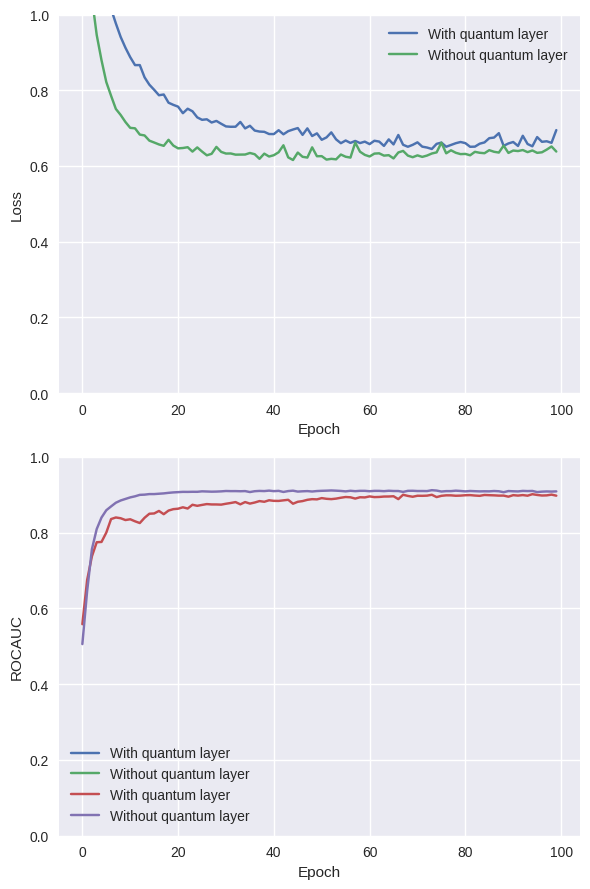

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 77.11%
Normal Model Accuracy: 77.57%
Hybrid Model F1 Score: 0.7475
Normal Model F1 Score: 0.7648
Hybrid Model AUC: 0.8997
Normal Model AUC: 0.9096
Hybrid Model AUPR: 0.5556
Normal Model AUPR: 0.5935


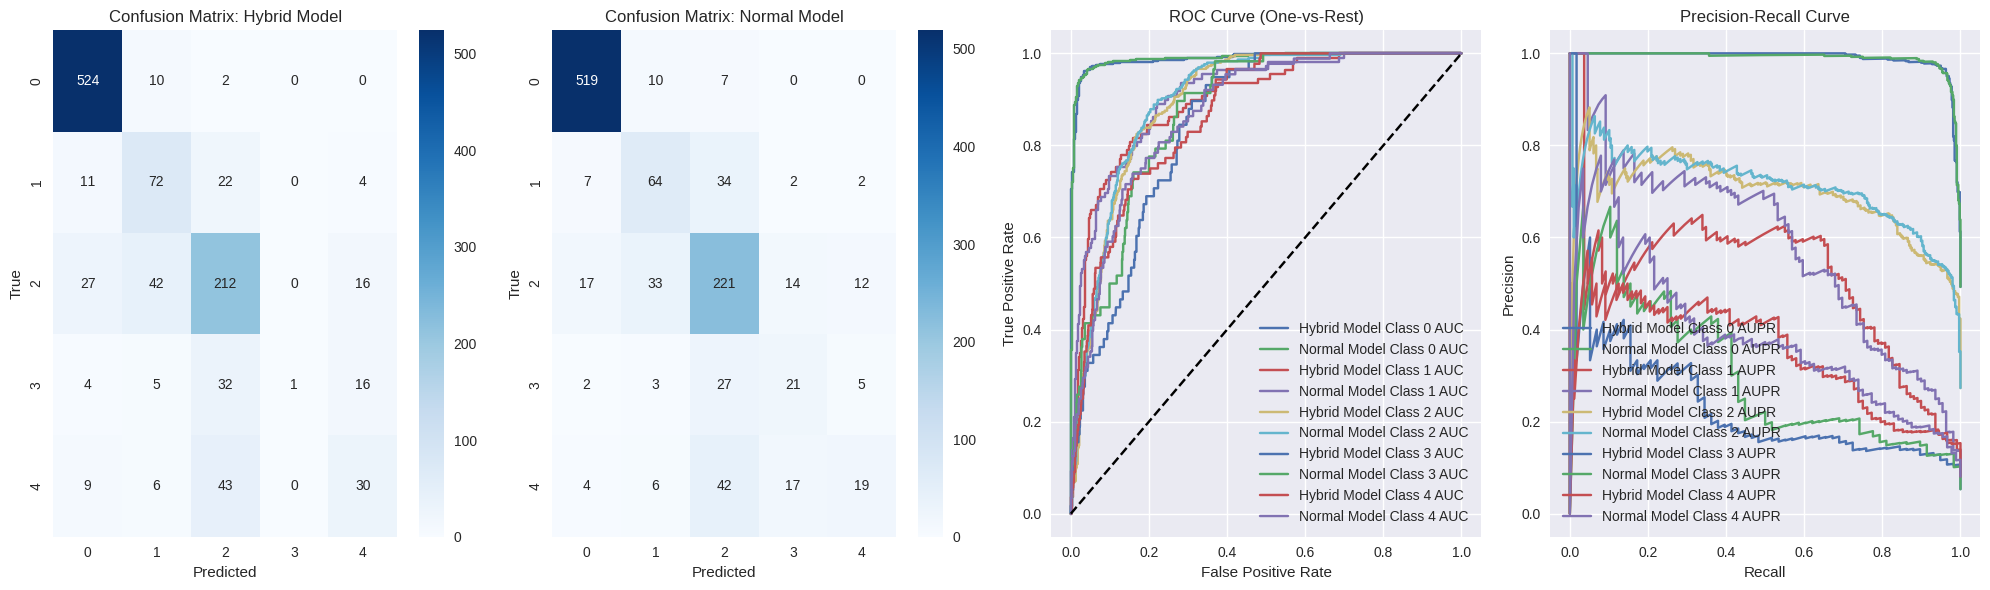

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 2

In [ ]:
seed = 42
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5976, Training Accuracy: 26.17%, Training AUROC: 0.4535
Validation Loss: 1.4086, Validation Accuracy: 38.87%, Validation AUROC: 0.4339
Epoch [2/100]
Training Loss: 1.2929, Training Accuracy: 48.83%, Training AUROC: 0.5654
Validation Loss: 1.2349, Validation Accuracy: 53.12%, Validation AUROC: 0.6141
Epoch [3/100]
Training Loss: 1.1430, Training Accuracy: 56.54%, Training AUROC: 0.7124
Validation Loss: 1.0876, Validation Accuracy: 62.50%, Validation AUROC: 0.7333
Epoch [4/100]
Training Loss: 1.0176, Training Accuracy: 64.26%, Training AUROC: 0.7841
Validation Loss: 0.9757, Validation Accuracy: 67.58%, Validation AUROC: 0.7926
Epoch [5/100]
Training Loss: 0.9275, Training Accuracy: 68.55%, Training AUROC: 0.8267
Validation Loss: 0.9036, Validation Accuracy: 68.95%, Validation AUROC: 0.8274
Epoch [6/100]
Training Loss: 0.8637, Training Accuracy: 70.41%, Training AUROC: 0.8460
Validation Loss: 0.8400, Validation Accuracy: 71.09%, Validation AUROC: 0.8470
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4586, Training Accuracy: 48.58%, Training AUROC: 0.5657
Validation Loss: 1.3781, Validation Accuracy: 49.02%, Validation AUROC: 0.6192
Epoch [2/100]
Training Loss: 1.3481, Training Accuracy: 49.32%, Training AUROC: 0.6422
Validation Loss: 1.3122, Validation Accuracy: 49.02%, Validation AUROC: 0.6788
Epoch [3/100]
Training Loss: 1.2986, Training Accuracy: 49.32%, Training AUROC: 0.6760
Validation Loss: 1.2690, Validation Accuracy: 49.02%, Validation AUROC: 0.6930
Epoch [4/100]
Training Loss: 1.2573, Training Accuracy: 49.32%, Training AUROC: 0.6855
Validation Loss: 1.2316, Validation Accuracy: 49.02%, Validation AUROC: 0.7006
Epoch [5/100]
Training Loss: 1.2239, Training Accuracy: 49.32%, Training AUROC: 0.6851
Validation Loss: 1.1941, Validation Accuracy: 49.22%, Validation AUROC: 0.7108
Epoch [6/100]
Training Loss: 1.1606, Training Accuracy: 62.16%, Training AUROC: 0.7368
Validation Loss: 1.1061, Validation Accuracy: 70.51%, Validation AUROC: 0.7837
Epoc

<ipython-input-25-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


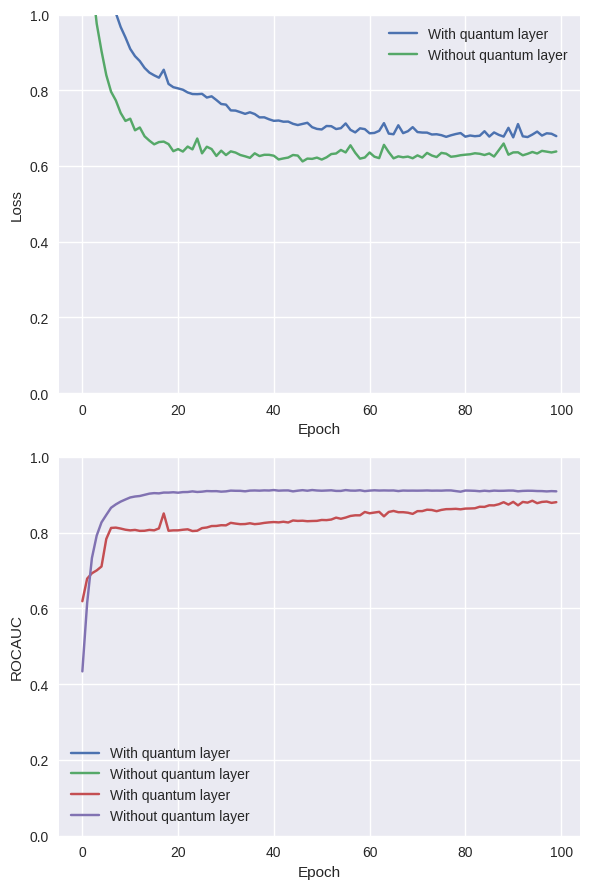

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 77.39%
Normal Model Accuracy: 77.39%
Hybrid Model F1 Score: 0.7251
Normal Model F1 Score: 0.7648
Hybrid Model AUC: 0.8904
Normal Model AUC: 0.9093
Hybrid Model AUPR: 0.5115
Normal Model AUPR: 0.5906


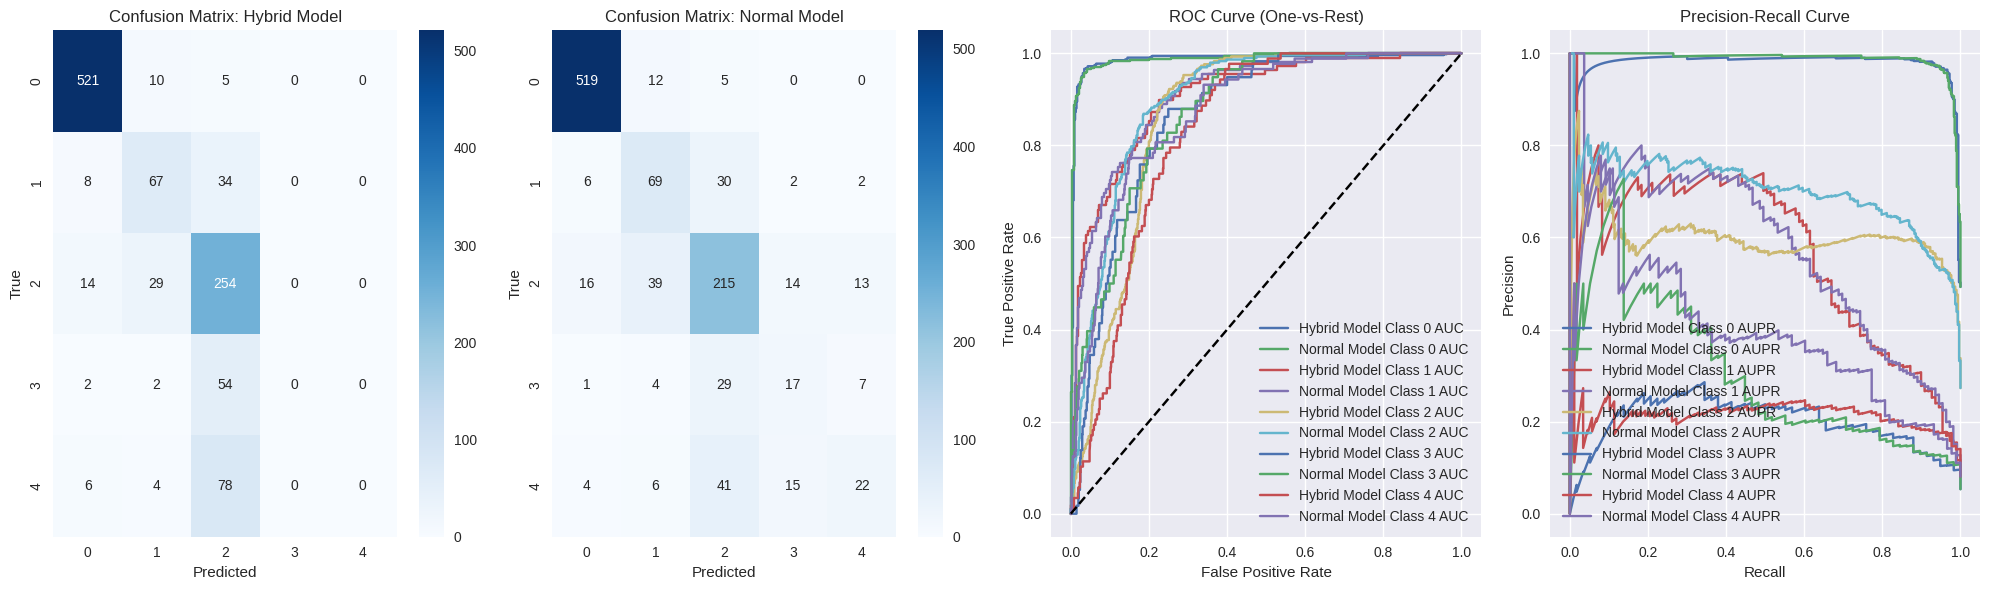

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 3

In [ ]:
seed = 5923
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4584, Training Accuracy: 41.75%, Training AUROC: 0.5400
Validation Loss: 1.3201, Validation Accuracy: 47.85%, Validation AUROC: 0.5387
Epoch [2/100]
Training Loss: 1.2235, Training Accuracy: 51.81%, Training AUROC: 0.6499
Validation Loss: 1.1707, Validation Accuracy: 52.93%, Validation AUROC: 0.6858
Epoch [3/100]
Training Loss: 1.0901, Training Accuracy: 58.79%, Training AUROC: 0.7502
Validation Loss: 1.0374, Validation Accuracy: 65.04%, Validation AUROC: 0.7677
Epoch [4/100]
Training Loss: 0.9773, Training Accuracy: 66.55%, Training AUROC: 0.8024
Validation Loss: 0.9416, Validation Accuracy: 68.16%, Validation AUROC: 0.8079
Epoch [5/100]
Training Loss: 0.9017, Training Accuracy: 68.60%, Training AUROC: 0.8305
Validation Loss: 0.8790, Validation Accuracy: 71.29%, Validation AUROC: 0.8320
Epoch [6/100]
Training Loss: 0.8390, Training Accuracy: 71.09%, Training AUROC: 0.8581
Validation Loss: 0.8231, Validation Accuracy: 71.68%, Validation AUROC: 0.8513
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4950, Training Accuracy: 40.14%, Training AUROC: 0.4490
Validation Loss: 1.3784, Validation Accuracy: 48.83%, Validation AUROC: 0.5004
Epoch [2/100]
Training Loss: 1.3196, Training Accuracy: 50.20%, Training AUROC: 0.6312
Validation Loss: 1.2649, Validation Accuracy: 52.93%, Validation AUROC: 0.7169
Epoch [3/100]
Training Loss: 1.2178, Training Accuracy: 57.32%, Training AUROC: 0.7626
Validation Loss: 1.1718, Validation Accuracy: 63.48%, Validation AUROC: 0.7987
Epoch [4/100]
Training Loss: 1.1437, Training Accuracy: 65.28%, Training AUROC: 0.8126
Validation Loss: 1.1075, Validation Accuracy: 69.14%, Validation AUROC: 0.8344
Epoch [5/100]
Training Loss: 1.0846, Training Accuracy: 68.75%, Training AUROC: 0.8298
Validation Loss: 1.0528, Validation Accuracy: 70.90%, Validation AUROC: 0.8492
Epoch [6/100]
Training Loss: 1.0360, Training Accuracy: 69.92%, Training AUROC: 0.8459
Validation Loss: 1.0062, Validation Accuracy: 71.48%, Validation AUROC: 0.8566
Epoc

<ipython-input-25-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


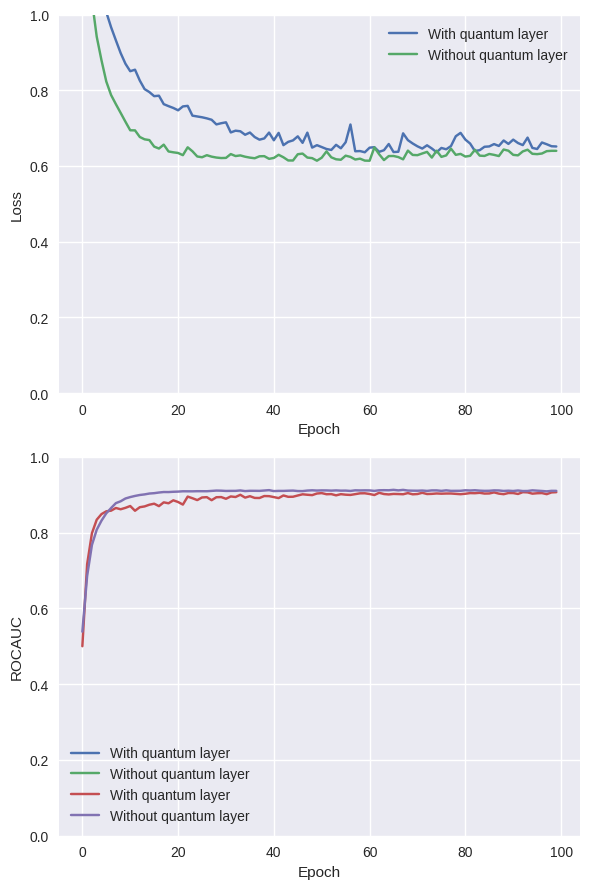

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 78.40%
Normal Model Accuracy: 78.12%
Hybrid Model F1 Score: 0.7553
Normal Model F1 Score: 0.7637
Hybrid Model AUC: 0.9001
Normal Model AUC: 0.9085
Hybrid Model AUPR: 0.5650
Normal Model AUPR: 0.5928


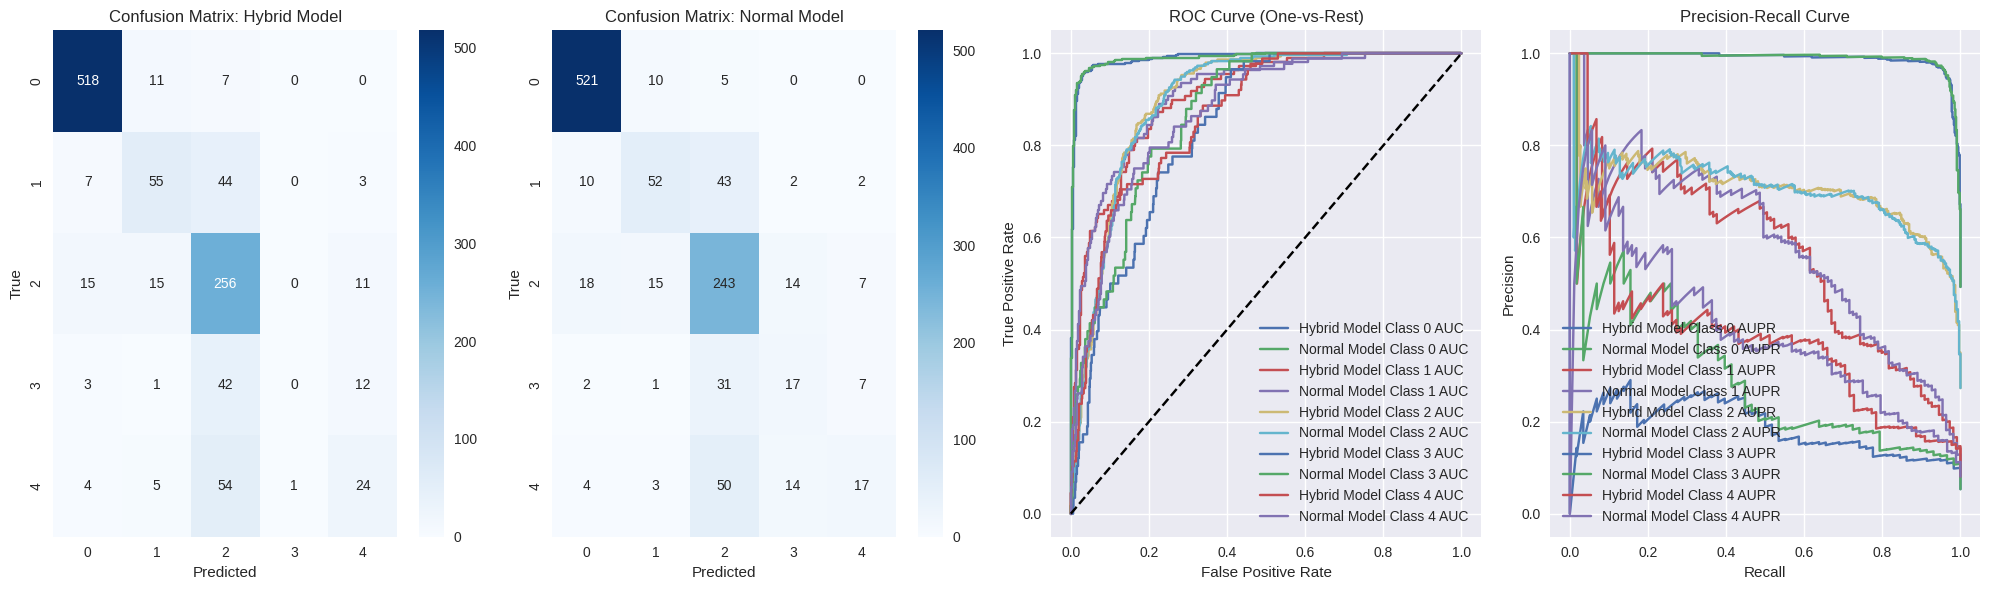

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 4

In [ ]:
seed = 8932
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.3810, Training Accuracy: 47.36%, Training AUROC: 0.5444
Validation Loss: 1.2628, Validation Accuracy: 54.30%, Validation AUROC: 0.5662
Epoch [2/100]
Training Loss: 1.1860, Training Accuracy: 57.81%, Training AUROC: 0.6498
Validation Loss: 1.1392, Validation Accuracy: 60.55%, Validation AUROC: 0.6820
Epoch [3/100]
Training Loss: 1.0776, Training Accuracy: 62.55%, Training AUROC: 0.7333
Validation Loss: 1.0292, Validation Accuracy: 64.65%, Validation AUROC: 0.7636
Epoch [4/100]
Training Loss: 0.9700, Training Accuracy: 67.33%, Training AUROC: 0.8043
Validation Loss: 0.9438, Validation Accuracy: 68.95%, Validation AUROC: 0.8066
Epoch [5/100]
Training Loss: 0.8983, Training Accuracy: 69.63%, Training AUROC: 0.8360
Validation Loss: 0.8760, Validation Accuracy: 70.51%, Validation AUROC: 0.8382
Epoch [6/100]
Training Loss: 0.8378, Training Accuracy: 71.34%, Training AUROC: 0.8534
Validation Loss: 0.8384, Validation Accuracy: 71.88%, Validation AUROC: 0.8560
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5366, Training Accuracy: 26.07%, Training AUROC: 0.4698
Validation Loss: 1.4286, Validation Accuracy: 48.24%, Validation AUROC: 0.4938
Epoch [2/100]
Training Loss: 1.3542, Training Accuracy: 52.29%, Training AUROC: 0.5187
Validation Loss: 1.3177, Validation Accuracy: 58.20%, Validation AUROC: 0.5757
Epoch [3/100]
Training Loss: 1.3080, Training Accuracy: 58.50%, Training AUROC: 0.5931
Validation Loss: 1.2888, Validation Accuracy: 59.18%, Validation AUROC: 0.6114
Epoch [4/100]
Training Loss: 1.2785, Training Accuracy: 61.04%, Training AUROC: 0.6198
Validation Loss: 1.2604, Validation Accuracy: 64.06%, Validation AUROC: 0.6303
Epoch [5/100]
Training Loss: 1.2527, Training Accuracy: 63.43%, Training AUROC: 0.6239
Validation Loss: 1.2367, Validation Accuracy: 69.53%, Validation AUROC: 0.6449
Epoch [6/100]
Training Loss: 1.2177, Training Accuracy: 66.80%, Training AUROC: 0.6390
Validation Loss: 1.2023, Validation Accuracy: 68.95%, Validation AUROC: 0.6518
Epoc

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

In [ ]:
model_normal = torch.load("/content/normal_model_8932.pth", weights_only=False)
model_hybrid = torch.load("/content/quantum_hybrid_model_8932.pth", weights_only=False)

Hybrid Model Accuracy: 77.94%
Normal Model Accuracy: 76.93%
Hybrid Model F1 Score: 0.7637
Normal Model F1 Score: 0.7609
Hybrid Model AUC: 0.9026
Normal Model AUC: 0.9081
Hybrid Model AUPR: 0.5683
Normal Model AUPR: 0.5840


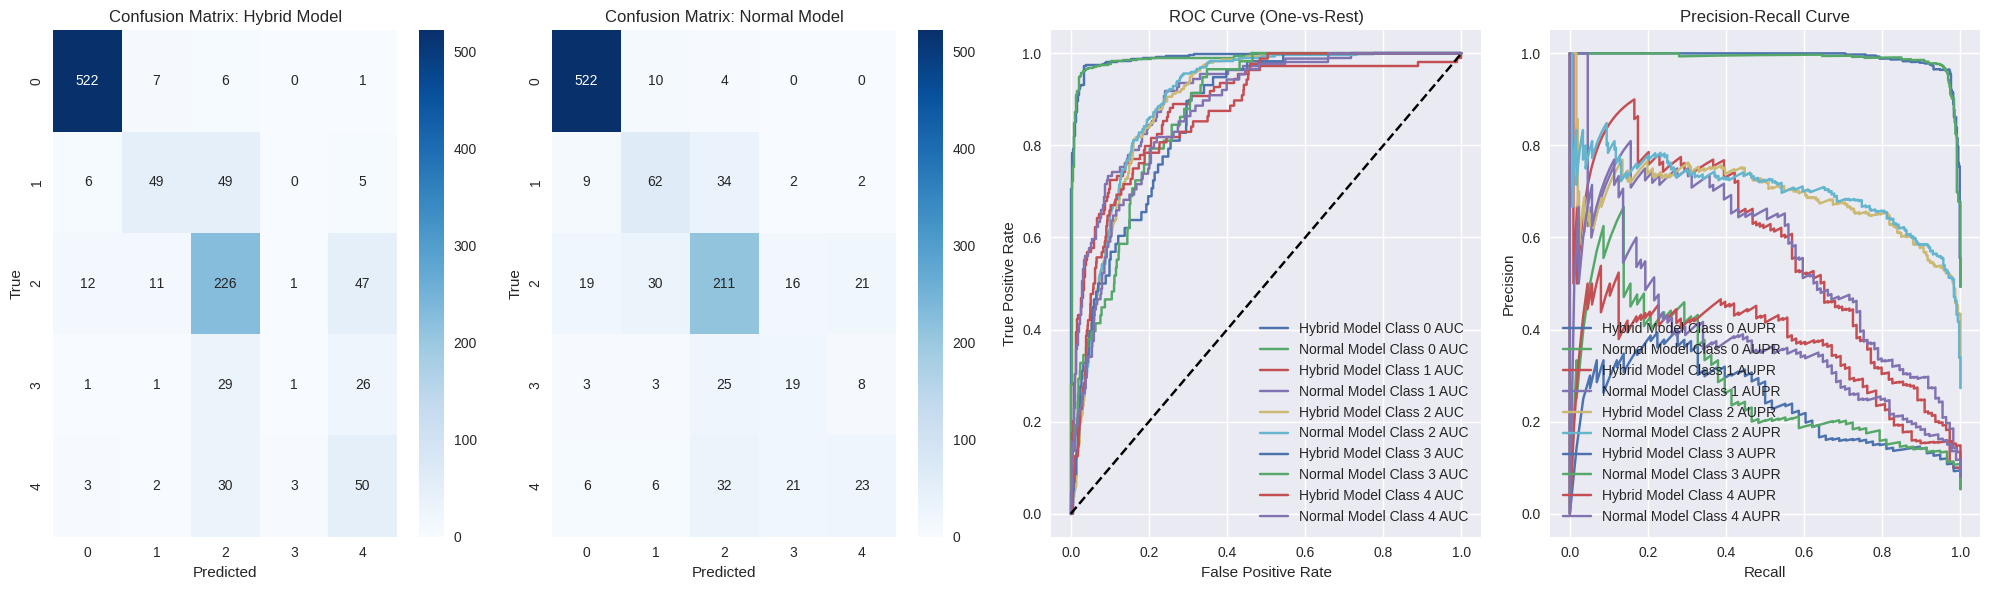

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 5

In [ ]:
seed = 56
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4715, Training Accuracy: 38.33%, Training AUROC: 0.5135
Validation Loss: 1.3076, Validation Accuracy: 50.78%, Validation AUROC: 0.5449
Epoch [2/100]
Training Loss: 1.2288, Training Accuracy: 54.59%, Training AUROC: 0.6138
Validation Loss: 1.1646, Validation Accuracy: 59.57%, Validation AUROC: 0.6902
Epoch [3/100]
Training Loss: 1.0961, Training Accuracy: 61.77%, Training AUROC: 0.7316
Validation Loss: 1.0277, Validation Accuracy: 64.84%, Validation AUROC: 0.7869
Epoch [4/100]
Training Loss: 0.9852, Training Accuracy: 65.92%, Training AUROC: 0.8030
Validation Loss: 0.9332, Validation Accuracy: 68.55%, Validation AUROC: 0.8336
Epoch [5/100]
Training Loss: 0.8956, Training Accuracy: 70.07%, Training AUROC: 0.8377
Validation Loss: 0.8618, Validation Accuracy: 69.53%, Validation AUROC: 0.8600
Epoch [6/100]
Training Loss: 0.8415, Training Accuracy: 70.65%, Training AUROC: 0.8568
Validation Loss: 0.8121, Validation Accuracy: 70.90%, Validation AUROC: 0.8715
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.3226, Training Accuracy: 48.58%, Training AUROC: 0.5373
Validation Loss: 1.2930, Validation Accuracy: 48.83%, Validation AUROC: 0.5948
Epoch [2/100]
Training Loss: 1.2685, Training Accuracy: 50.15%, Training AUROC: 0.6365
Validation Loss: 1.2496, Validation Accuracy: 53.52%, Validation AUROC: 0.6772
Epoch [3/100]
Training Loss: 1.2233, Training Accuracy: 57.91%, Training AUROC: 0.6921
Validation Loss: 1.1985, Validation Accuracy: 62.30%, Validation AUROC: 0.7385
Epoch [4/100]
Training Loss: 1.1619, Training Accuracy: 64.21%, Training AUROC: 0.7351
Validation Loss: 1.1284, Validation Accuracy: 66.41%, Validation AUROC: 0.7299
Epoch [5/100]
Training Loss: 1.0990, Training Accuracy: 68.07%, Training AUROC: 0.7392
Validation Loss: 1.0736, Validation Accuracy: 70.70%, Validation AUROC: 0.7357
Epoch [6/100]
Training Loss: 1.0548, Training Accuracy: 69.63%, Training AUROC: 0.7523
Validation Loss: 1.0272, Validation Accuracy: 69.53%, Validation AUROC: 0.7777
Epoc

<ipython-input-25-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


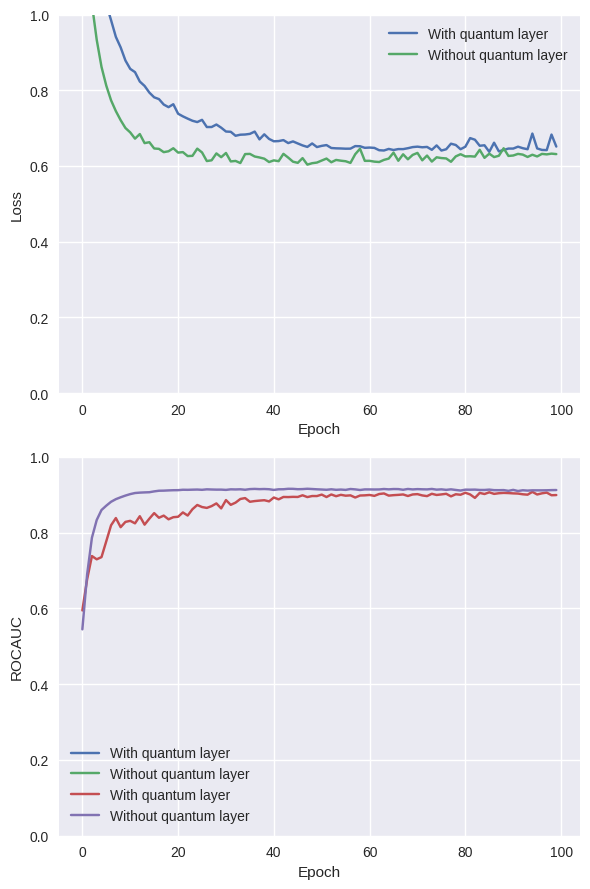

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 77.11%
Normal Model Accuracy: 78.40%
Hybrid Model F1 Score: 0.7486
Normal Model F1 Score: 0.7654
Hybrid Model AUC: 0.8994
Normal Model AUC: 0.9096
Hybrid Model AUPR: 0.5634
Normal Model AUPR: 0.5952


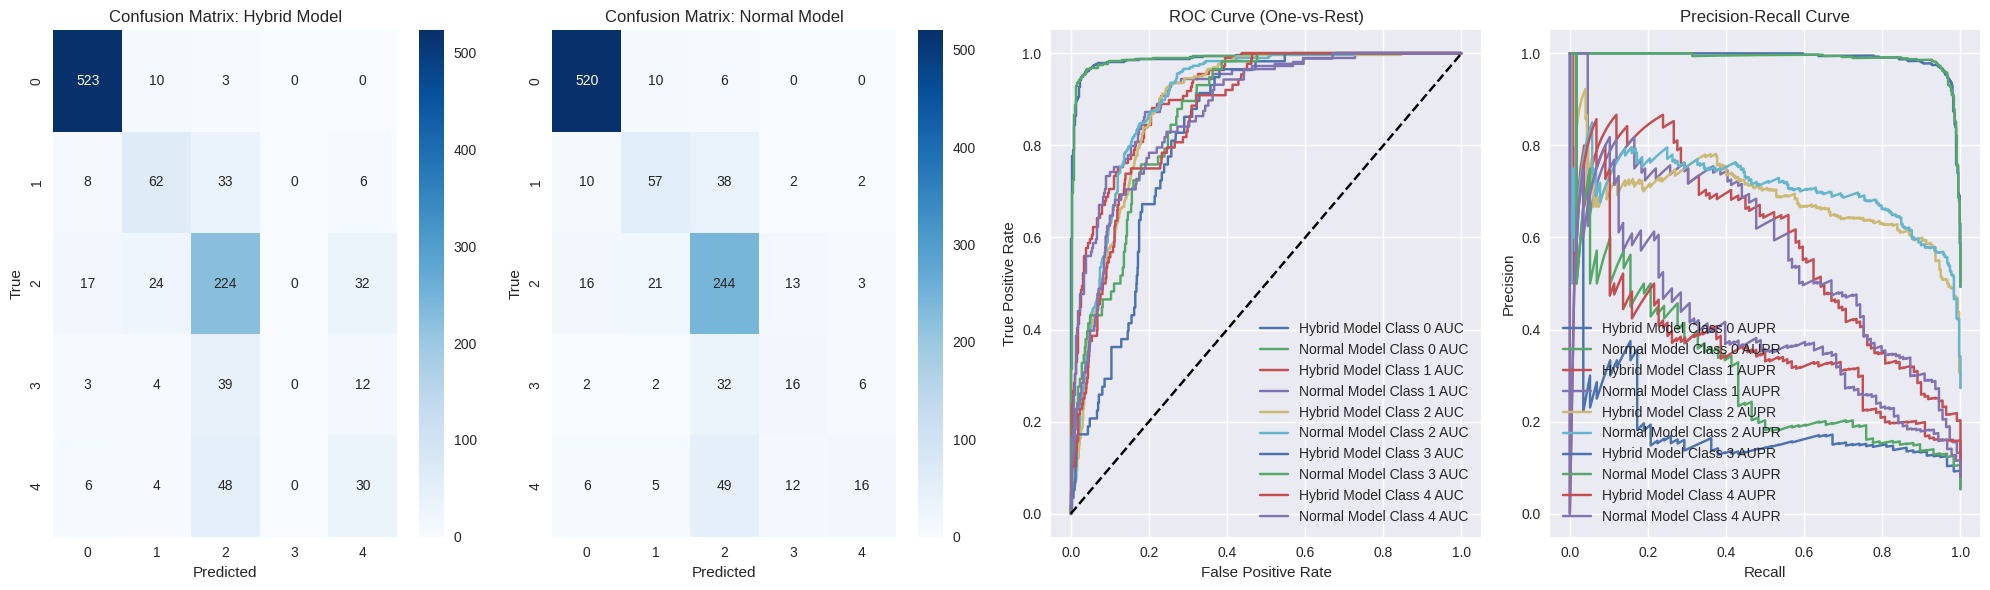

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

# Experimenting APTOS on IDRID and Messidor

## Experimenting APTOS on IDRID

In [ ]:
batch_size = 32
dataset = "IDRID"
num_classes=5
q_depth = 4

In [ ]:
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)

### Testing Model From Seed 1

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/normal_model_0.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/quantum_hybrid_model_0.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Hybrid Model Accuracy: 42.19%
Normal Model Accuracy: 56.25%
Hybrid Model F1 Score: 0.3352
Normal Model F1 Score: 0.5231
Hybrid Model AUC: 0.7425
Normal Model AUC: 0.8000
Hybrid Model AUPR: 0.3841
Normal Model AUPR: 0.4457


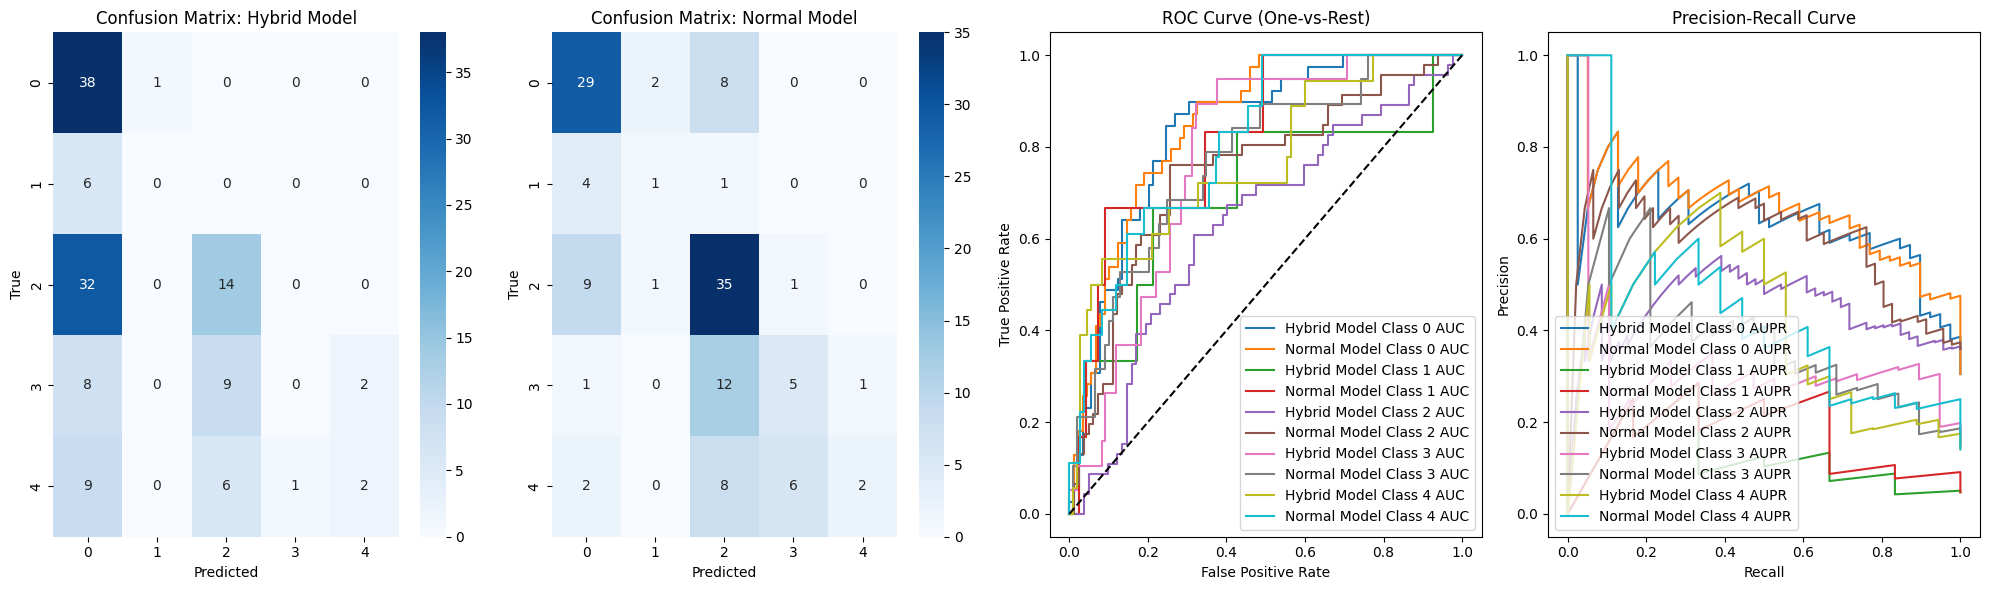

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 2

Hybrid Model Accuracy: 47.66%
Normal Model Accuracy: 55.47%
Hybrid Model F1 Score: 0.3962
Normal Model F1 Score: 0.5101
Hybrid Model AUC: 0.7315
Normal Model AUC: 0.7959
Hybrid Model AUPR: 0.3659
Normal Model AUPR: 0.4545


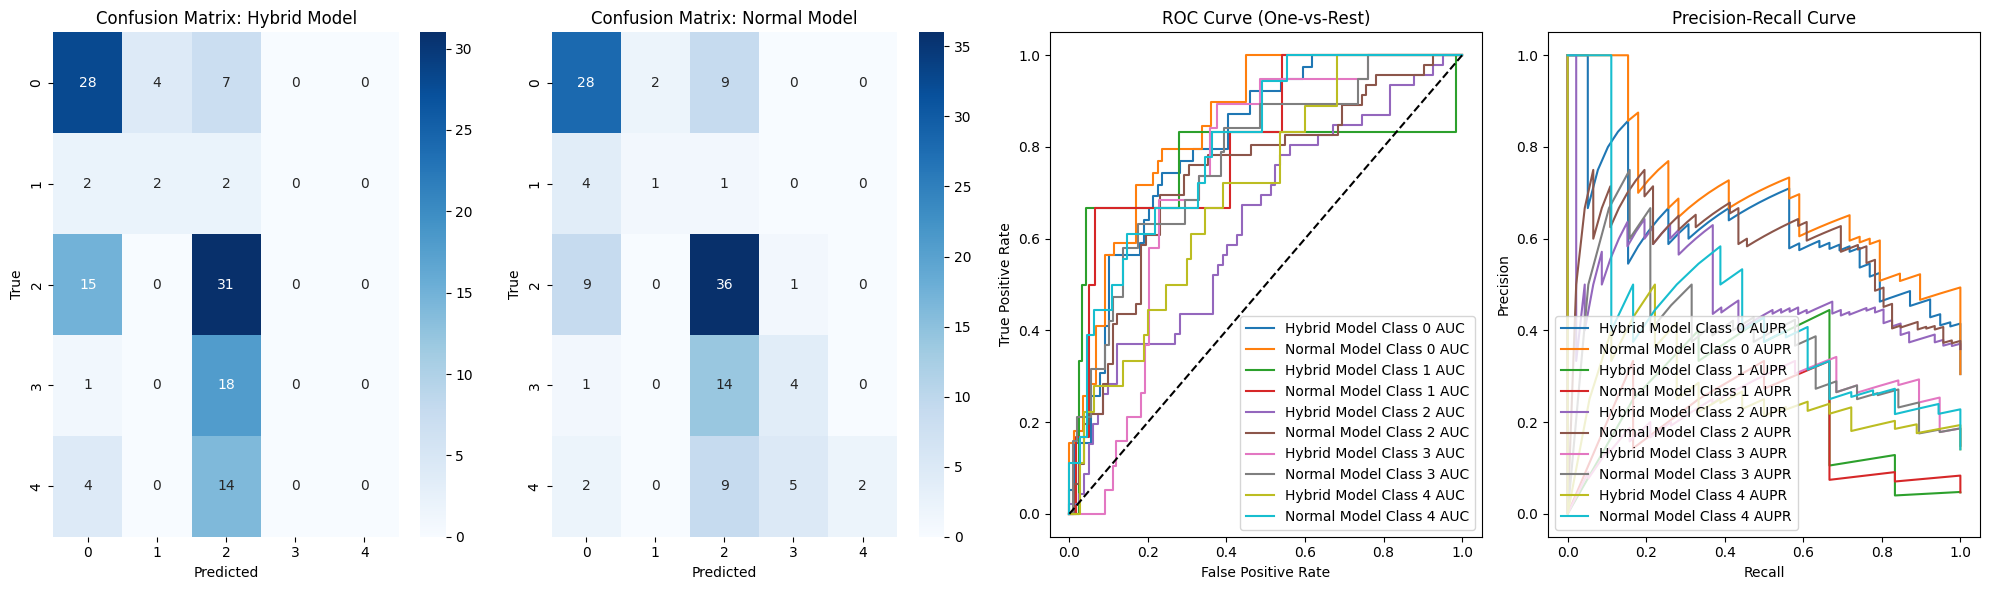

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/normal_model_42.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/quantum_hybrid_model_42.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 3

Hybrid Model Accuracy: 42.97%
Normal Model Accuracy: 53.12%
Hybrid Model F1 Score: 0.3744
Normal Model F1 Score: 0.4709
Hybrid Model AUC: 0.7492
Normal Model AUC: 0.7917
Hybrid Model AUPR: 0.4028
Normal Model AUPR: 0.4398


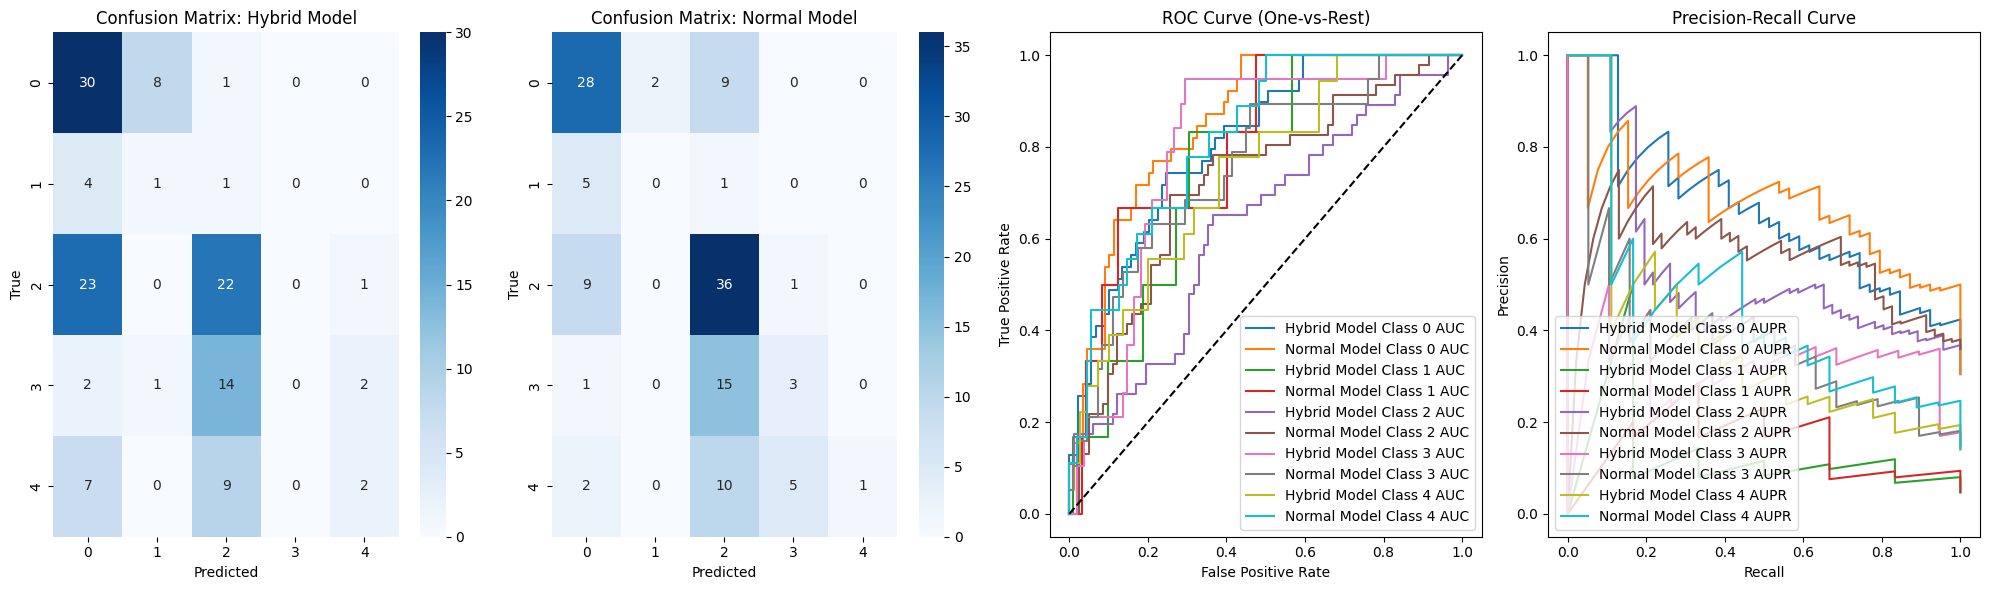

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/normal_model_56.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/quantum_hybrid_model_56.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 4

Hybrid Model Accuracy: 50.78%
Normal Model Accuracy: 53.12%
Hybrid Model F1 Score: 0.4579
Normal Model F1 Score: 0.4743
Hybrid Model AUC: 0.7686
Normal Model AUC: 0.7981
Hybrid Model AUPR: 0.4414
Normal Model AUPR: 0.4560


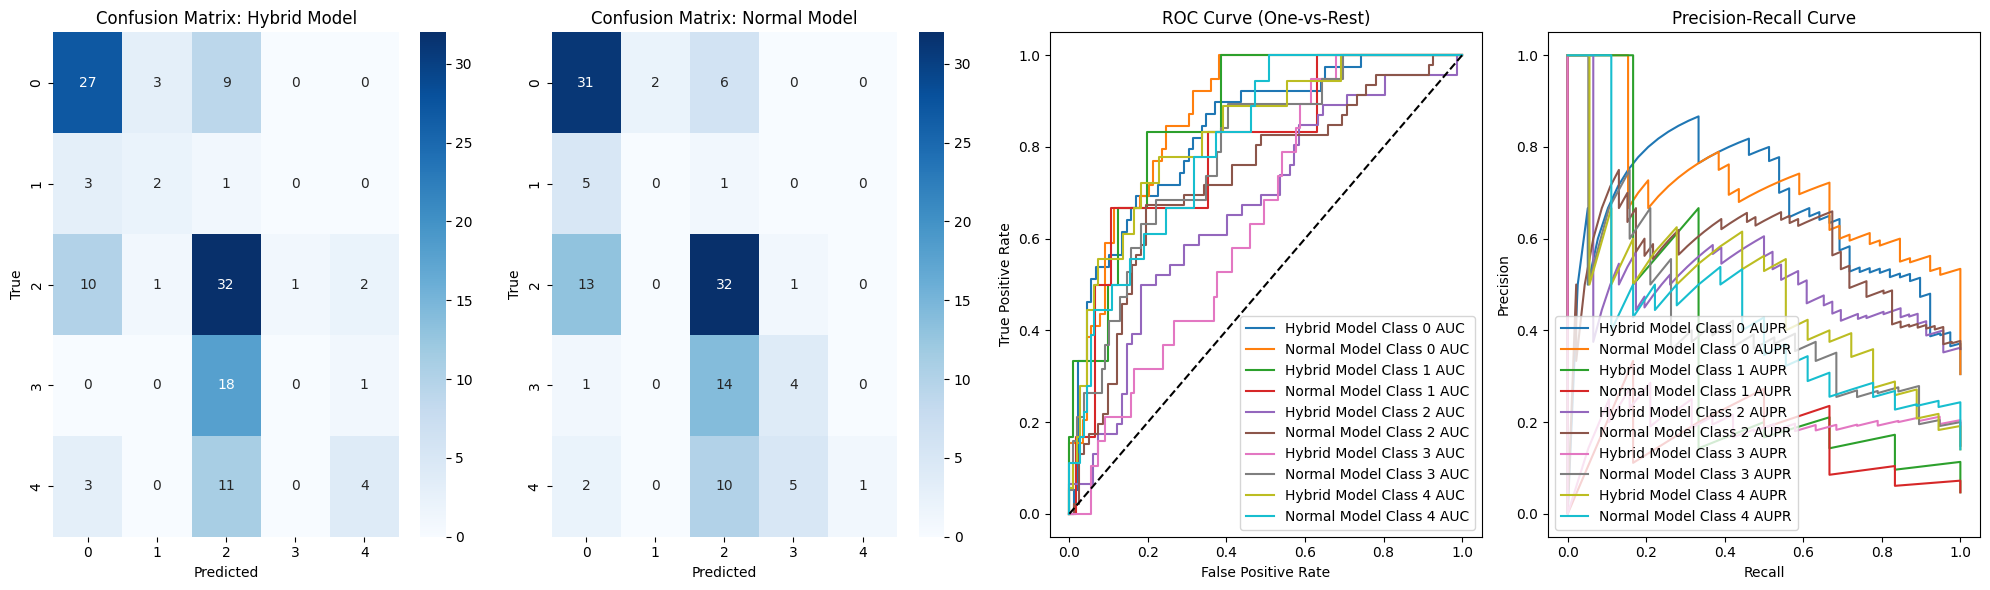

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/normal_model_5923.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/quantum_hybrid_model_5923.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 5

Hybrid Model Accuracy: 48.44%
Normal Model Accuracy: 55.47%
Hybrid Model F1 Score: 0.4351
Normal Model F1 Score: 0.5172
Hybrid Model AUC: 0.7550
Normal Model AUC: 0.7957
Hybrid Model AUPR: 0.4144
Normal Model AUPR: 0.4544


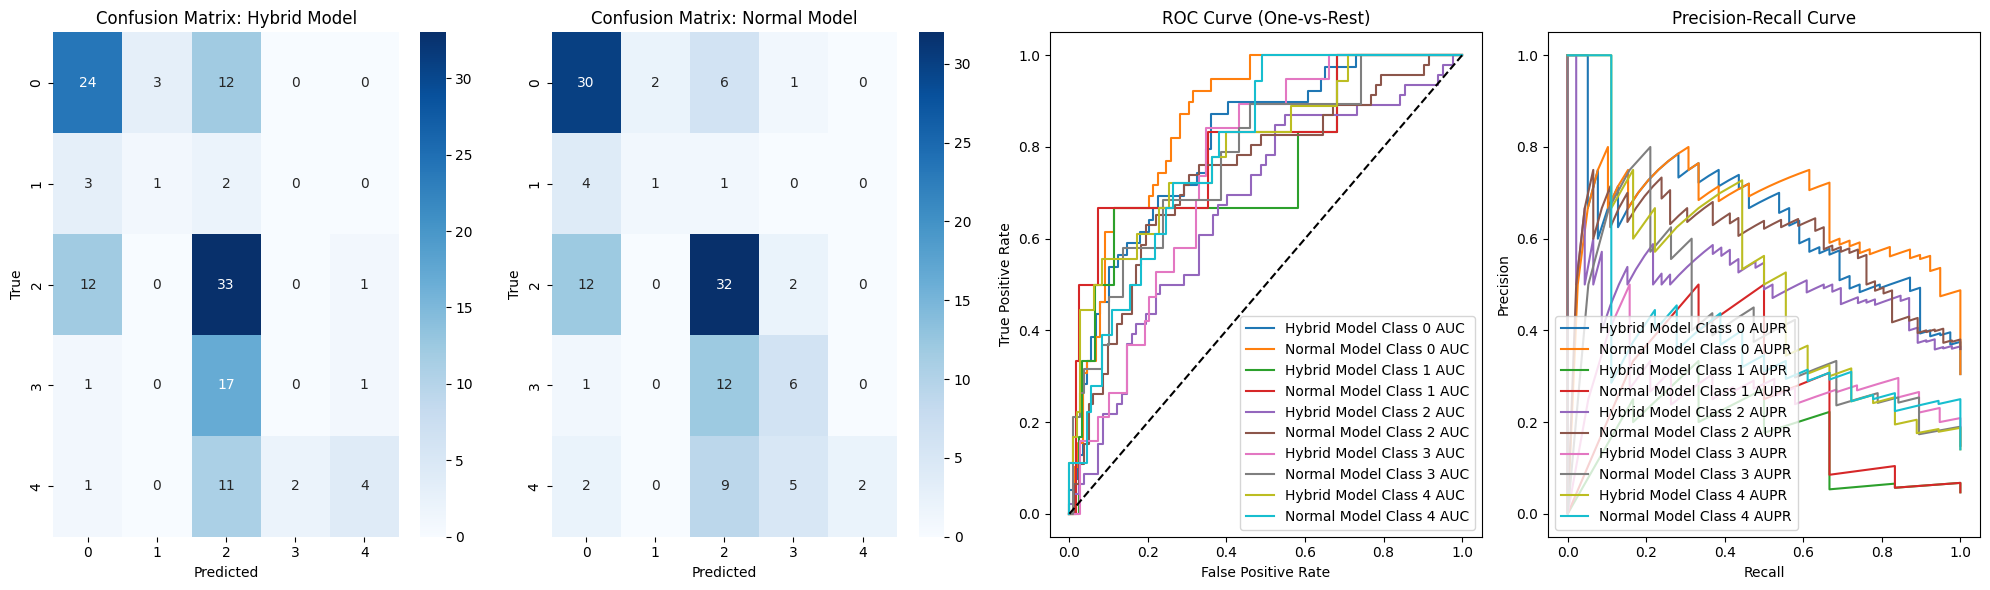

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/normal_model_8932.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/quantum_hybrid_model_8932.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

## Experimenting APTOS on Messidor

In [ ]:
dataset = "Messidor"
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)

### Testing Model from Seed 1

Hybrid Model Accuracy: 56.45%
Normal Model Accuracy: 51.17%
Hybrid Model F1 Score: 0.4531
Normal Model F1 Score: 0.4874
Hybrid Model AUC: 0.6855
Normal Model AUC: 0.7258
Hybrid Model AUPR: 0.3387
Normal Model AUPR: 0.3253


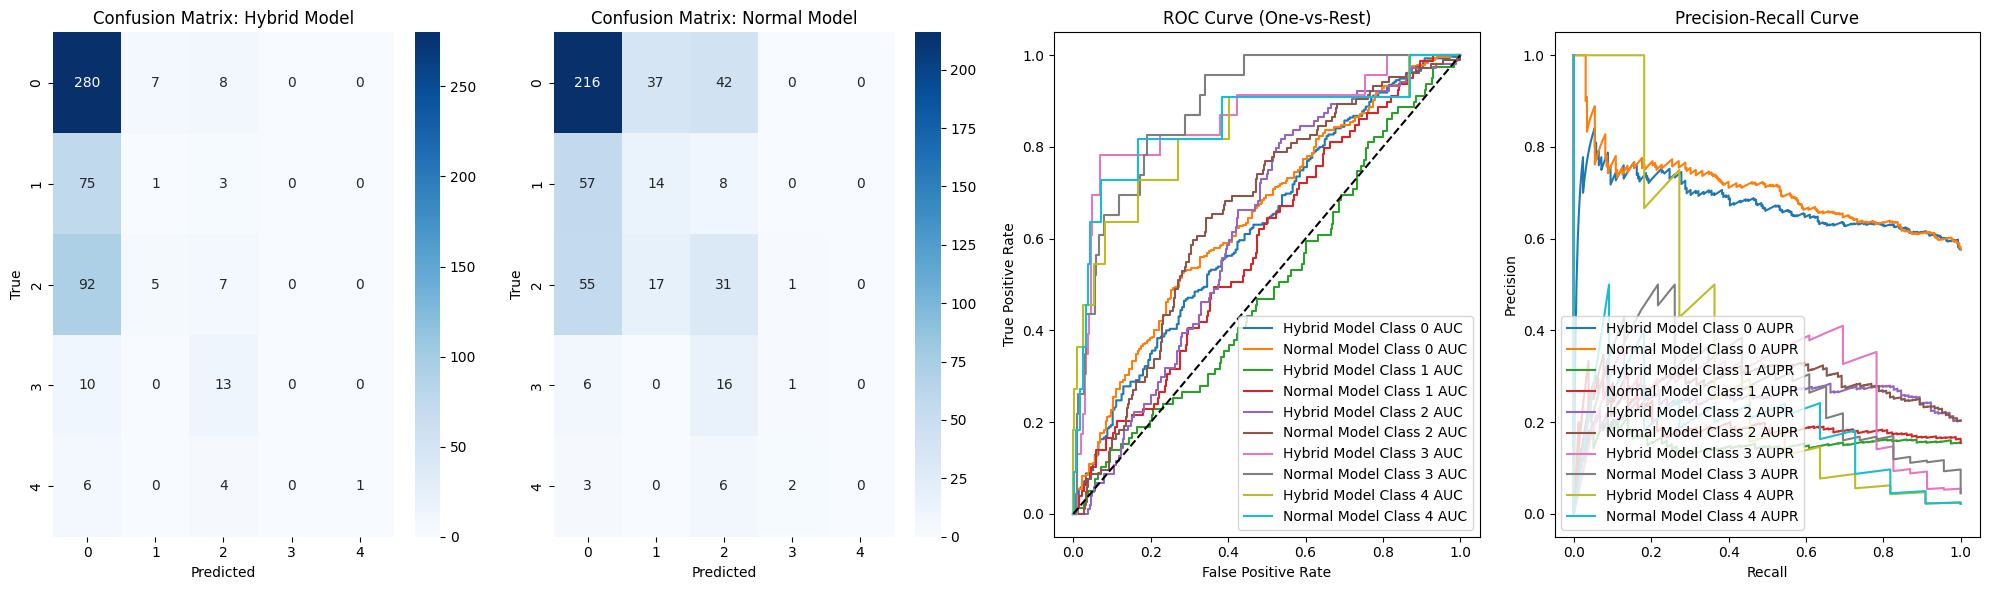

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/normal_model_0.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/quantum_hybrid_model_0.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 2

Hybrid Model Accuracy: 55.66%
Normal Model Accuracy: 49.02%
Hybrid Model F1 Score: 0.4690
Normal Model F1 Score: 0.4735
Hybrid Model AUC: 0.7169
Normal Model AUC: 0.7224
Hybrid Model AUPR: 0.3172
Normal Model AUPR: 0.3254


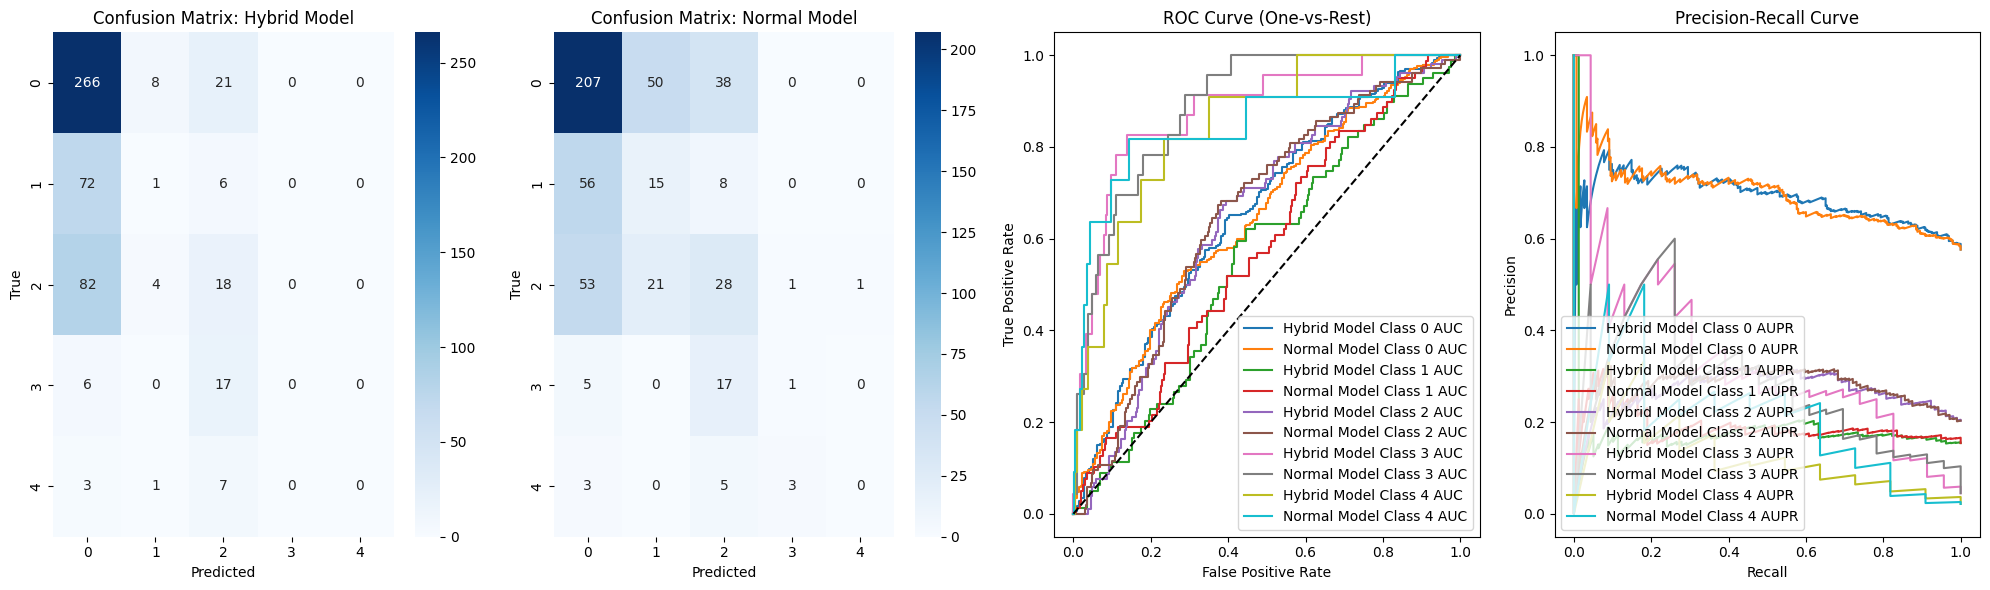

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/normal_model_42.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/quantum_hybrid_model_42.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 3

Hybrid Model Accuracy: 55.86%
Normal Model Accuracy: 55.27%
Hybrid Model F1 Score: 0.4535
Normal Model F1 Score: 0.5047
Hybrid Model AUC: 0.6950
Normal Model AUC: 0.7263
Hybrid Model AUPR: 0.3325
Normal Model AUPR: 0.3494


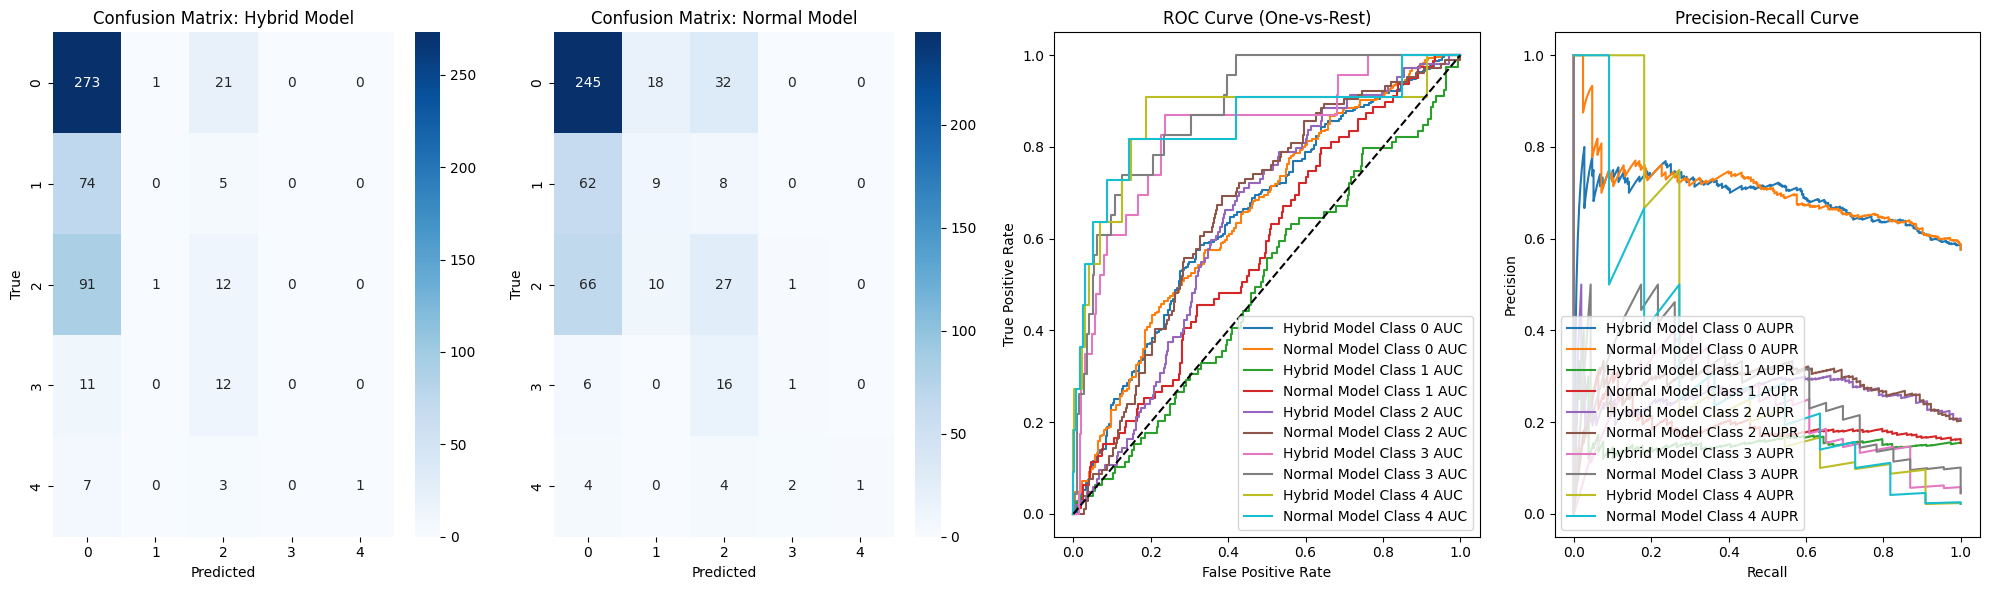

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/normal_model_56.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/quantum_hybrid_model_56.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 4

Hybrid Model Accuracy: 53.52%
Normal Model Accuracy: 53.91%
Hybrid Model F1 Score: 0.4699
Normal Model F1 Score: 0.4972
Hybrid Model AUC: 0.6968
Normal Model AUC: 0.7259
Hybrid Model AUPR: 0.3269
Normal Model AUPR: 0.3403


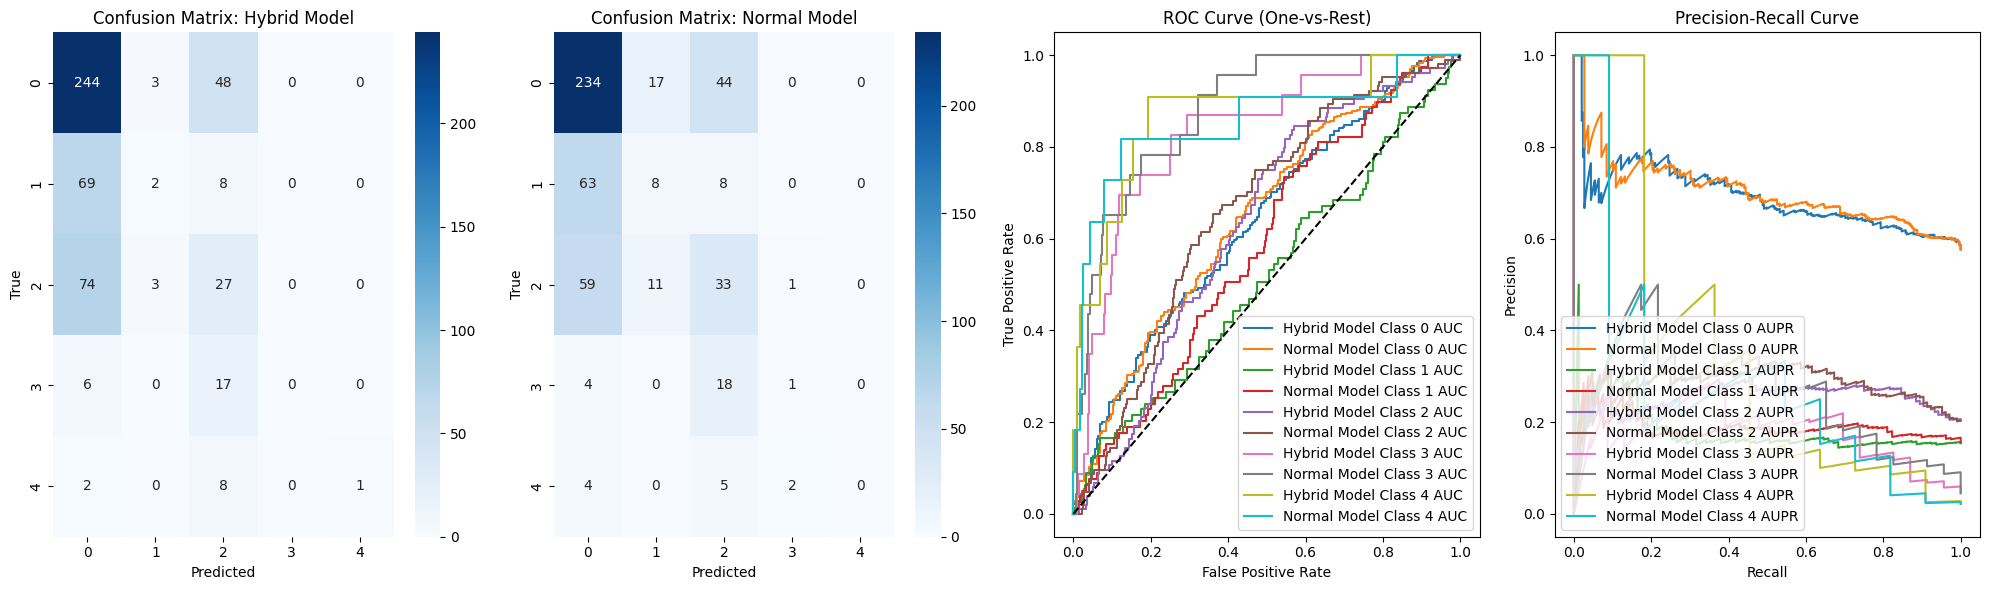

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/normal_model_5923.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/quantum_hybrid_model_5923.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 5

Hybrid Model Accuracy: 54.49%
Normal Model Accuracy: 54.30%
Hybrid Model F1 Score: 0.4823
Normal Model F1 Score: 0.4945
Hybrid Model AUC: 0.6807
Normal Model AUC: 0.7249
Hybrid Model AUPR: 0.3192
Normal Model AUPR: 0.3528


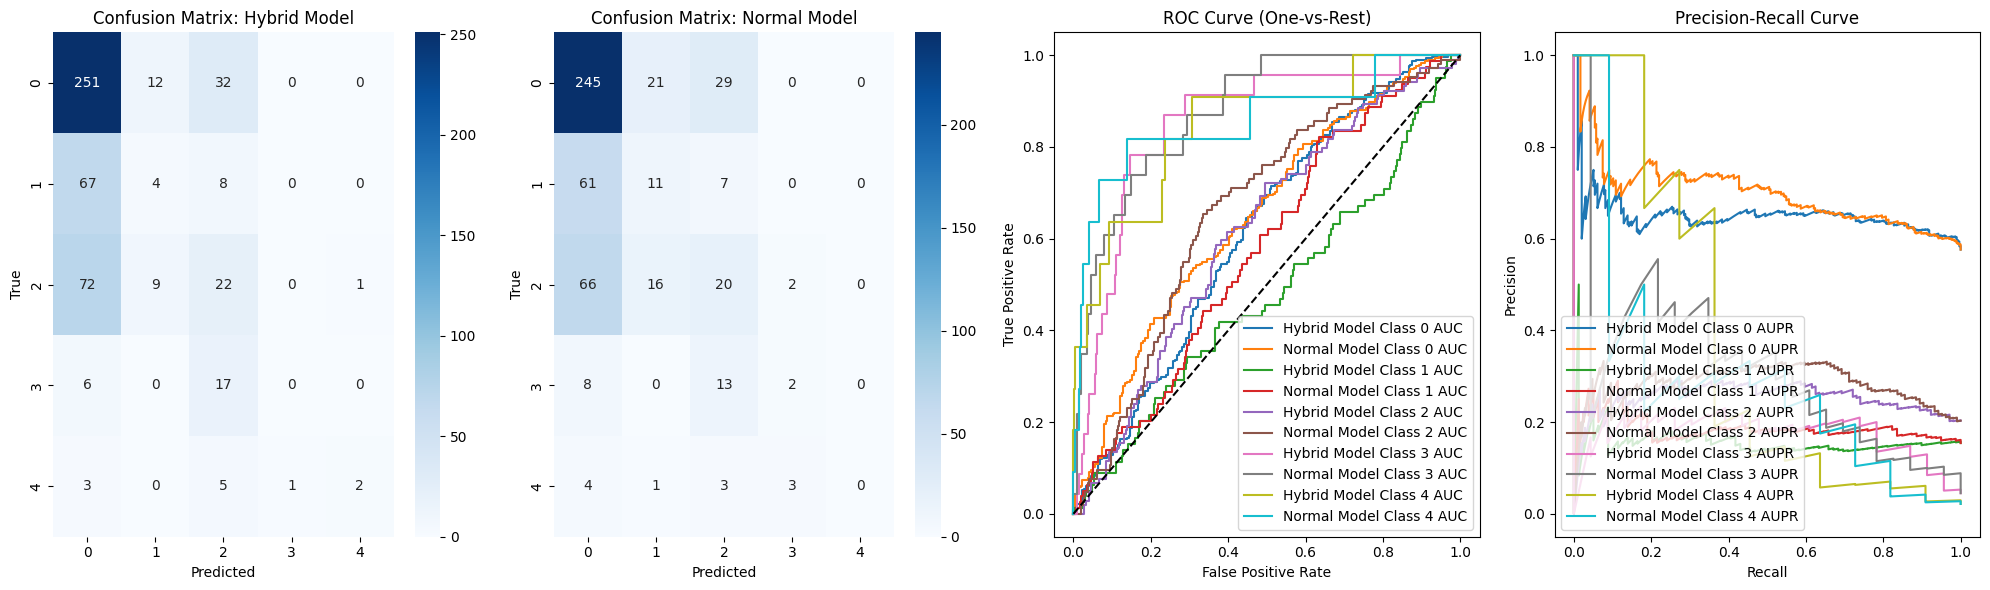

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/normal_model_8932.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS_models/quantum_hybrid_model_8932.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)